In [11]:

import numpy as np
import arquivos_suporte_mpc_dpi as sdpi
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, FFMpegWriter, ImageMagickWriter
import scienceplots
import latex




In [9]:
# Crie um objeto para as funções de suporte.
suporte=sdpi.DadoSuporteDpi()
constantes=suporte.constantes
 
# Carrega os valores constantes necessários no arquivo principal
Ts=constantes['Ts']
saidas=constantes['saidas'] # número de saídas (psi, Y)
hz = constantes['hz'] # horizonte de previsao
#x_dot=constantes['x_dot'] # velocidade longitudinal constante
intervalo_de_tempo=constantes['intervalo_de_tempo'] # duração da manobra


# Gera os sinais de referência
t=np.arange(0,intervalo_de_tempo+Ts,Ts) # tempo de 0 a 10 segundos, tempo de amostragem (Ts=0,1 segundo)
#r=constantes['r']
#f=constantes['f']
X_ref, phi1_ref, phi2_ref = suporte.gerador_de_trajetoria(t)
sim_length=len(t) # Número de iterações de controle no loop
#refSignals=np.zeros(len(X_ref)*saidas)
xr=np.linspace(0,t[-1],num=len(t)) #[inicio,fim,qtd de elementos]
refSignals=np.zeros(len(xr)*saidas)


# Constroi o vetor de sinal de referência:
# refSignal = [X_ref_0, phi1_ref_0, phi2_ref_0, X_ref_1, phi1_ref_1, phi2_ref_1,... etc.]
k=0
for i in range(0,len(refSignals),saidas):
    refSignals[i]= X_ref[k]
    refSignals[i+1]= phi1_ref[k]
    refSignals[i+2]= phi2_ref[k]
    k=k+1

# Carrega os estados iniciais
# Se você quiser colocar números aqui, certifique-se de que eles sejam flutuantes e não
# inteiros. Isso significa que você deve adicionar um ponto aí.
# Exemplo: Por favor escreva 0. em vez de 0 ( adicione o ponto para ser float)
Xp = 0.
phi1 = 0.2
phi2 = -0.2
Xp_dot = 0.
phi1_dot = 0.
phi2_dot = 0.

estados=np.array([Xp, phi1, phi2, Xp_dot, phi1_dot, phi2_dot])
estadosTotal=np.zeros((len(t),len(estados))) # Acompanhará todos os seus estados durante toda a manobra
estadosTotal[0][0:len(estados)]=estados

x_opt_total = np.zeros((len(t),hz))
phi1_opt_total=np.zeros((len(t),hz))
phi2_opt_total=np.zeros((len(t),hz))

# Carrega a entrada inicial
U1 = 0. # Entrada em t = -1 s 
UTotal=np.zeros(len(t)) # Para acompanhar todas as entradas ao longo do tempo
UTotal[0]=U1


# Para extrair x do x_aug_opt previsto
C_x_opt=np.zeros((hz,(len(estados)+np.size(U1))*hz))
for i in range(0,hz):
    C_x_opt[i][i+6*(i)]=1

# Para extrair phi1_opt do x_aug_opt previsto
C_phi1_opt=np.zeros((hz,(len(estados)+np.size(U1))*hz))
for i in range(1,hz+1):
    C_phi1_opt[i-1][i+6*(i-1)]=1

# Para extrair phi2_opt do x_aug_opt previsto
C_phi2_opt=np.zeros((hz,(len(estados)+np.size(U1))*hz))
for i in range(2,hz+2):
    C_phi2_opt[i-2][i+6*(i-2)]=1




# Gera as matrizes discretas do espaço de estado
Ad,Bd,Cd,Dd=suporte.espaco_de_estados()

Hdb,Fdbt,Cdb,Adc=suporte.mpc_otimizacao(Ad,Bd,Cd,Dd,hz)

# Inicia o controlador - loops de simulação
k=0
for i in range(0,sim_length-1):

    # Gera o estado atual aumentado e o vetor de referência
    x_aug_t=np.transpose([np.concatenate((estados,[U1]),axis=0)])

    # Do vetor refSignals, extraia apenas os valores de referência de sua [amostra atual (AGORA) + Ts] para [AGORA+período do horizonte (hz)]
    # Exemplo: t_now tem 3 segundos, hz = 15 amostras, então dos vetores refSignals, você move os elementos para o vetor r:
    # r=[psi_ref_3.1, Y_ref_3.1, psi_ref_3.2, Y_ref_3.2, ..., psi_ref_4.5, Y_ref_4.5]
    # A cada loop, tudo muda em 0,1 segundo porque Ts=0,1 s
    k=k+saidas
    if k+saidas*hz<=len(refSignals):
        r1=refSignals[k:k+saidas*hz]
        #print(r)
    else:
        r1=refSignals[k:len(refSignals)]
        hz=hz-1
        #print(r)

    if hz<constantes['hz']: # Verifica se hz começa a diminuir
        # Essas matrizes (Hdb,Fdbt,Cdb,Adc) foram criadas anteriormente no início do loop.
        # Eles são constantes durante quase toda a simulação. No entanto,
        # ao final da simulação, o período do horizonte (hz) começa a diminuir.
        # Portanto, as matrizes precisam ser constantemente atualizadas ao final da simulação.
        Hdb,Fdbt,Cdb,Adc=suporte.mpc_otimizacao(Ad,Bd,Cd,Dd,hz)
    
    ft=np.matmul(np.concatenate((np.transpose(x_aug_t)[0][0:len(x_aug_t)],r1),axis=0),Fdbt)
    du=-np.matmul(np.linalg.inv(Hdb),np.transpose([ft]))
    x_aug_opt=np.matmul(Cdb,du)+np.matmul(Adc,x_aug_t)
    
    x_opt =  np.matmul(C_x_opt[0:hz,0:(len(estados)+np.size(U1))*hz],x_aug_opt)
    phi1_opt=np.matmul(C_phi1_opt[0:hz,0:(len(estados)+np.size(U1))*hz],x_aug_opt)
    phi2_opt=np.matmul(C_phi2_opt[0:hz,0:(len(estados)+np.size(U1))*hz],x_aug_opt)
    
    
    # if hz<4:
    #     print(x_aug_opt)
    x_opt = np.transpose((x_opt))[0]
    x_opt_total[i+1][0:hz]=x_opt

    phi1_opt=np.transpose((phi1_opt))[0]
    phi1_opt_total[i+1][0:hz]=phi1_opt

    phi2_opt=np.transpose((phi2_opt))[0]
    phi2_opt_total[i+1][0:hz]=phi2_opt

    # Atualize as entradas reais
    U1=U1+du[0][0]
    

    # Estabeleça os limites para as entradas reais (máx.: pi/6 radianos)
    limite_entrada =6 #2.5 para angulo 0.1
    if U1 < - limite_entrada:
        U1 = -limite_entrada
    elif U1 > limite_entrada:
        U1=limite_entrada
    else:
        U1=U1

    # Acompanhe as entradas conforme passa de t = 0 -> t = 7 segundos
    UTotal[i+1]=U1

    # Calcula novos estados no sistema de malha aberta (intervalo: Ts/30)
    estados=suporte.novos_estados_malha_aberta(estados,U1)
    estadosTotal[i+1][0:len(estados)]=estados




[[  0.        ]
 [  0.        ]
 [  0.        ]
 [  0.77814879]
 [-10.01336453]
 [  3.35116609]]


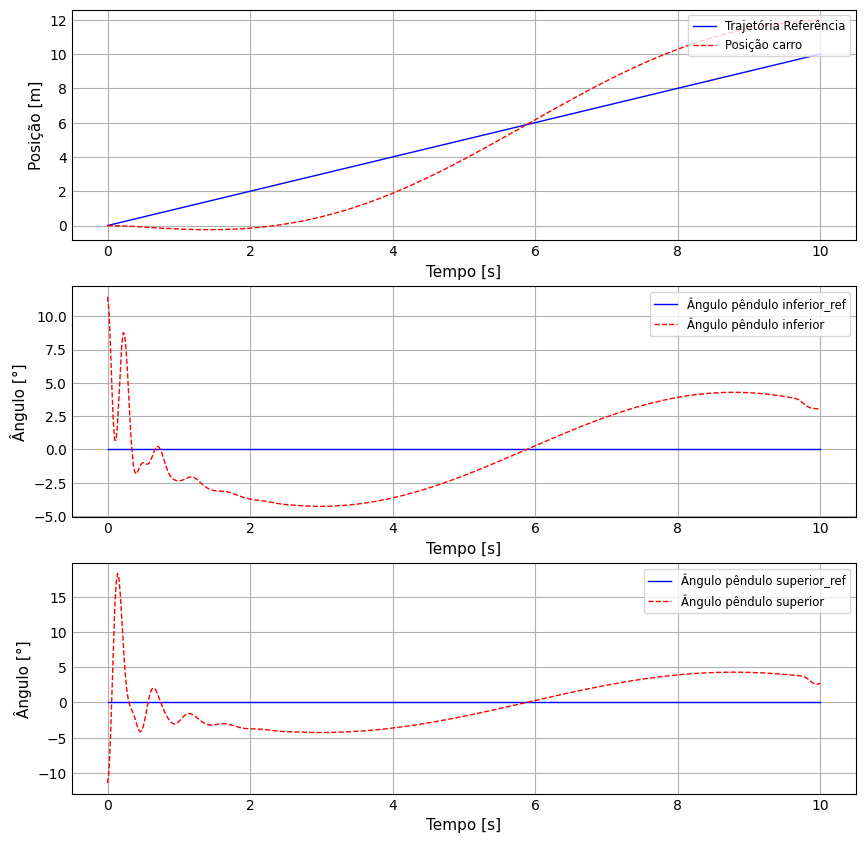

In [10]:
#plt.style.use(['science','ggplot'])
plt.style.use('_mpl-gallery')
plt.figure(figsize=(8,8))

# Plot the the input delta(t) and the outputs: psi(t) and Y(t)
plt.subplot(3,1,1)
plt.plot(t,X_ref,'b',linewidth=1,label='Trajetória Referência')
plt.plot(t,estadosTotal[:,0],'--r',linewidth=1,label='Posição carro')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Posição [m]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,2)
plt.plot(t,phi1_ref,'b',linewidth=1,label='Ângulo pêndulo inferior_ref')
plt.plot(t,estadosTotal[:,1]*(180/np.pi),'--r',linewidth=1,label='Ângulo pêndulo inferior')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Ângulo [°]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.subplot(3,1,3)
plt.plot(t,phi2_ref,'b',linewidth=1,label='Ângulo pêndulo superior_ref')
plt.plot(t,estadosTotal[:,2]*(180/np.pi),'--r',linewidth=1,label='Ângulo pêndulo superior')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Ângulo [°]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()



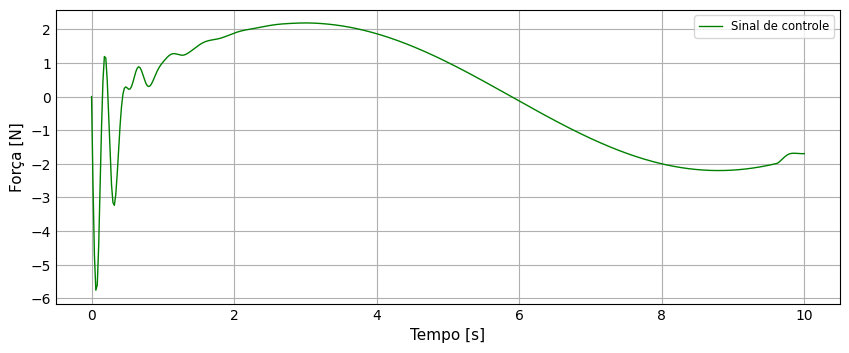

In [4]:
plt.figure(figsize=(8,3))
plt.plot(t,UTotal[:],'g',linewidth=1,label='Sinal de controle')
plt.xlabel('Tempo [s]',fontsize=11)
plt.ylabel('Força [N]',fontsize=11)
plt.grid(True)
plt.legend(loc='upper right',fontsize='small')

plt.show()